In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 500)
import os
plots_folder = "./plots/mortality"
os.system(f"mkdir -p {plots_folder}")


df_mor=pd.read_csv("https://raw.githubusercontent.com/akarlinsky/world_mortality/main/world_mortality.csv")

In [315]:
df_mor.country_name.unique()

array(['Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bermuda', 'Bolivia', 'Bosnia', 'Brazil', 'Brunei', 'Bulgaria',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Estonia', 'Faroe Islands', 'Finland',
       'France', 'French Guiana', 'French Polynesia', 'Georgia',
       'Germany', 'Gibraltar', 'Greece', 'Greenland', 'Guadeloupe',
       'Guatemala', 'Hong Kong', 'Hungary', 'Iceland', 'Iran', 'Ireland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',
       'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Malaysia',
       'Maldives', 'Malta', 'Martinique', 'Mauritius', 'Mayotte',
       'Mexico', 'Moldova', 'Monaco', 'Mongolia

In [277]:
df_mor_baseline = df_mor[df_mor.year < 2020]
df_mor_baseline = df_mor_baseline.groupby(["country_name","time"]).agg(
    mean_deaths=("deaths", "mean"),
    std_deaths=("deaths", "std"),
    var_deaths=("deaths", "var"),
).reset_index()

In [278]:
df_mor_baseline

,country_name,time,mean_deaths,std_deaths,var_deaths
0,Albania,1,2447.8,418.005622,174728.7
1,Albania,2,1975.2,111.960707,12535.2
2,Albania,3,1980.8,123.432978,15235.7
3,Albania,4,1747.6,113.125152,12797.3
4,Albania,5,1698.6,35.913786,1289.8
...,...,...,...,...,...
3485,Uzbekistan,8,12252.8,699.172153,488841.7
3486,Uzbekistan,9,10857.2,214.839940,46156.2
3487,Uzbekistan,10,11917.8,293.722999,86273.2
3488,Uzbekistan,11,12830.4,533.678555,284812.8


In [279]:
df_mor = df_mor.merge(df_mor_baseline, on=["country_name","time"],how="left")
df_mor["excess_deaths"] = df_mor["deaths"] - df_mor["mean_deaths"]
df_mor["excess_deaths_hi"] = df_mor["deaths"] - (df_mor["mean_deaths"] - 1.645 * df_mor["std_deaths"])
df_mor["excess_deaths_lo"] = df_mor["deaths"] - (df_mor["mean_deaths"] + 1.645 * df_mor["std_deaths"])
df_mor["cumulative_excess_deaths"] = df_mor.groupby(['country_name','year'])['excess_deaths'].apply(lambda x: x.cumsum())
df_mor["std_cumulative_excess_deaths"] = df_mor.groupby(['country_name','year'])['var_deaths'].apply(lambda x: np.sqrt(x.cumsum()))
df_mor["cumulative_excess_deaths_hi"] = df_mor["cumulative_excess_deaths"] + 1.645 * df_mor["std_cumulative_excess_deaths"]
df_mor["cumulative_excess_deaths_lo"] = df_mor["cumulative_excess_deaths"] - 1.645 * df_mor["std_cumulative_excess_deaths"]


In [280]:
df_mor[["cumulative_excess_deaths","excess_deaths","var_deaths","std_cumulative_excess_deaths"]]

,cumulative_excess_deaths,excess_deaths,var_deaths,std_cumulative_excess_deaths
0,42.2,42.2,174728.7,418.005622
1,206.0,163.8,12535.2,432.739991
2,276.2,70.2,15235.7,449.999556
3,434.6,158.4,12797.3,464.000970
4,445.0,10.4,1289.8,465.388762
...,...,...,...,...
23448,17540.4,8955.2,488841.7,2150.504011
23449,20139.2,2598.8,46156.2,2161.208852
23450,21922.4,1783.2,86273.2,2181.077005
23451,22073.0,150.6,284812.8,2245.419716


In [356]:
def plot_mortality(varname: str, country: str):
   
    plt.figure(figsize=(10,5),dpi=100)
    for year in [2020, 2021]:
        df_plt = df_mor[(df_mor.year==year) & (df_mor.country_name==country)]
        if len(df_plt.index) == 0:
            raise ValueError(f"Wrong country name: {country}")
        x_max = 55
        interval = 2
        if df_plt.time_unit.unique() == "monthly":
            x_max = 13
            interval = 1
        plt.plot(df_plt.time, df_plt[varname], label=year, linewidth=1.8)
        if varname != "deaths":
            plt.fill_between(df_plt.time, 
                             df_plt[varname+"_lo"], 
                             df_plt[varname+"_hi"],alpha=0.1)
    df_base = df_mor_baseline[df_mor_baseline.country_name==country]
    if varname == "deaths":
        plt.plot(df_base.time, df_base.mean_deaths, label="baseline", 
             linewidth=1.8, color="black",linestyle="dashed")
        plt.fill_between(df_base.time, 
                         df_base.mean_deaths - 1.645*df_base.std_deaths, 
                         df_base.mean_deaths + 1.645*df_base.std_deaths,
                         alpha=0.1,
                         color="black"
                        )
    else:
        plt.axhline(y=0, color='black', linestyle='dashed',linewidth=1.8)
    plt.grid()
    plt.legend()
    label = "Week of the year"
    if x_max < 50:
        label = "Month of the year"
    plt.xlabel(label, fontsize=12)
    plt.title(f"{country} {varname}".replace("_"," "), fontsize=15)
    plt.ylabel("N. deaths", fontsize=12)
    plt.xticks(np.arange(0, x_max ,interval))
    plt.savefig(f"{plots_folder}/{country}_{varname}.png", bbox_inches="tight")

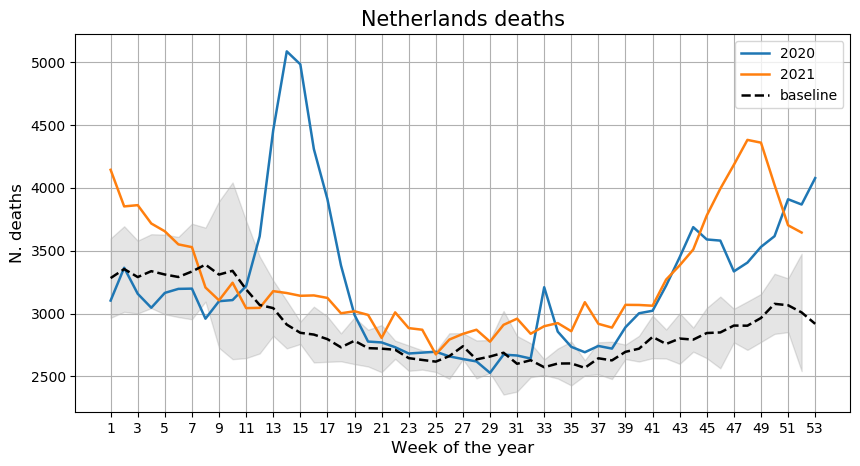

In [339]:
plot_mortality(varname="deaths",
               country="Netherlands")

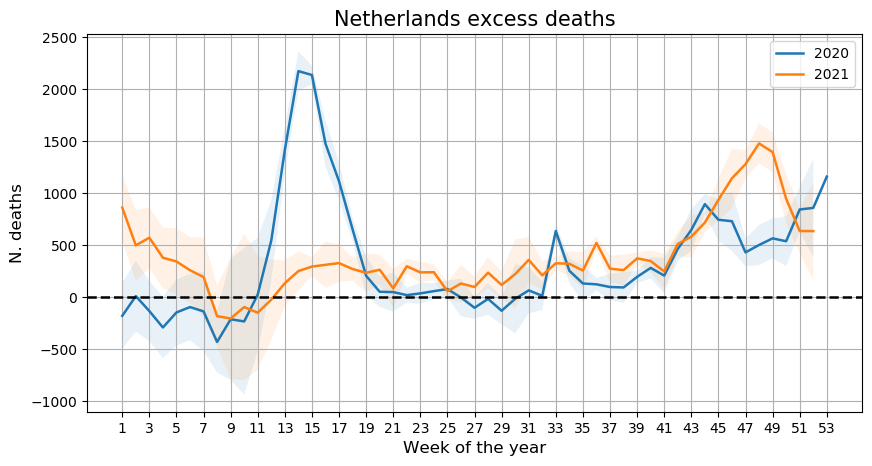

In [340]:
plot_mortality(varname="excess_deaths",
               country="Netherlands")

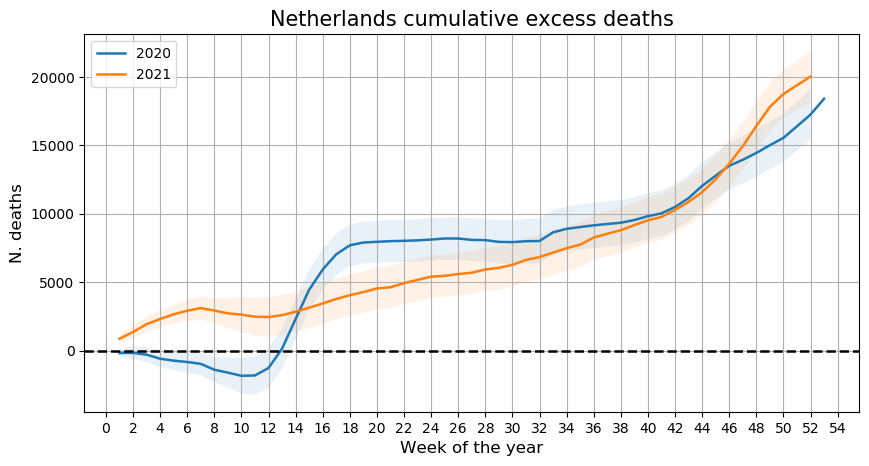

In [251]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Netherlands")

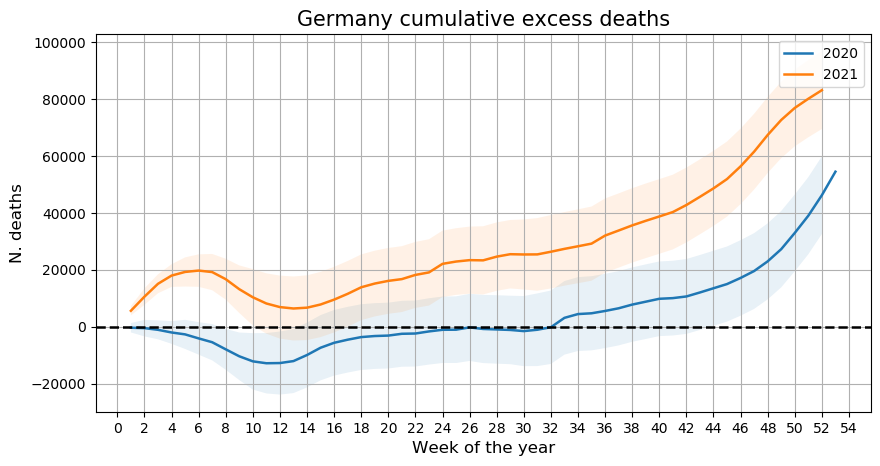

In [256]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Germany")

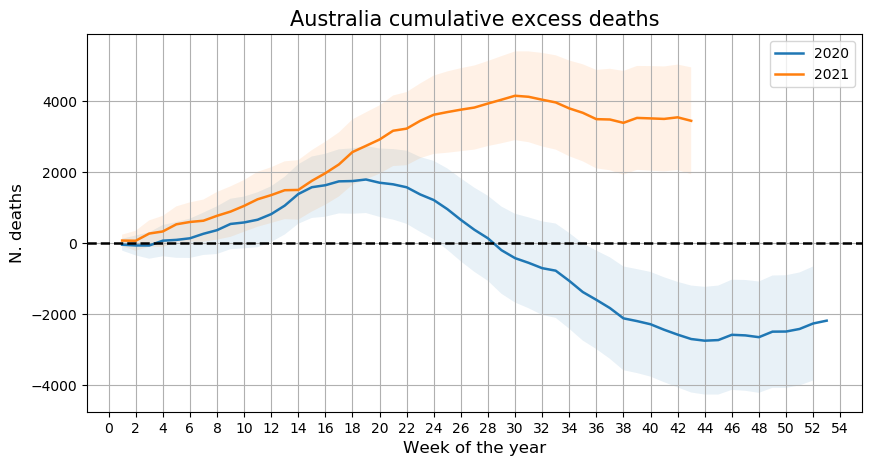

In [260]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Australia")

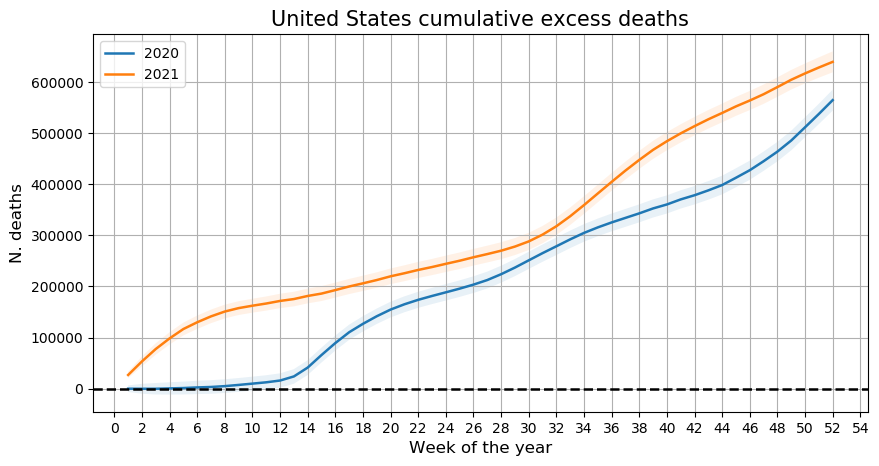

In [261]:
plot_mortality(varname="cumulative_excess_deaths",
               country="United States")

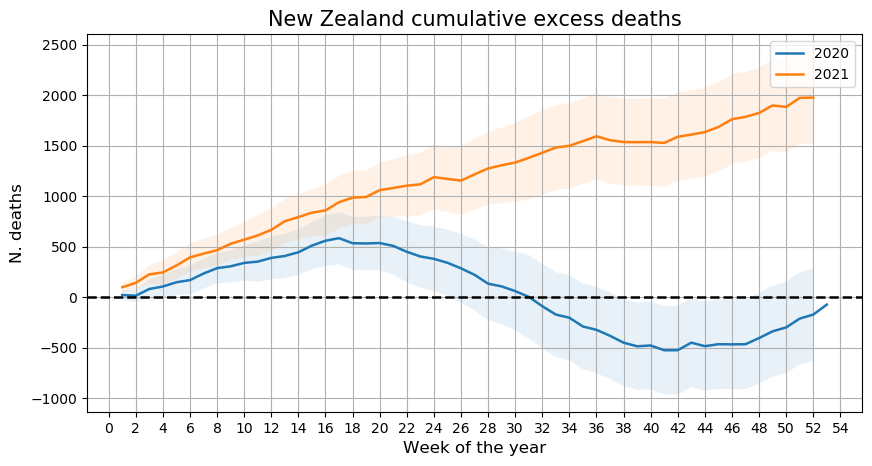

In [267]:
plot_mortality(varname="cumulative_excess_deaths",
               country="New Zealand")

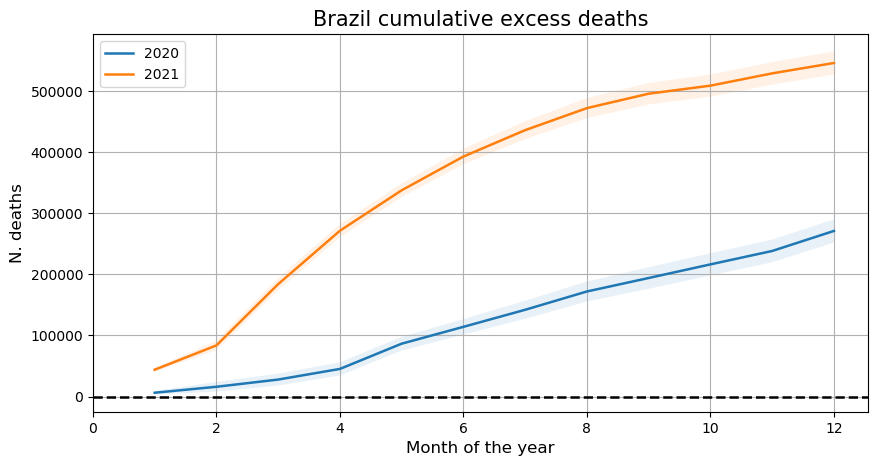

In [285]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Brazil")

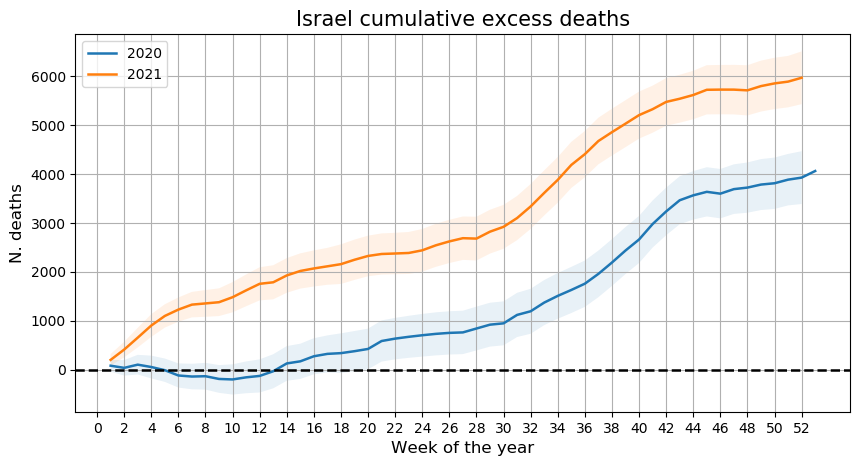

In [286]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Israel")

In [289]:
df_mor.country_name.unique()

array(['Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bermuda', 'Bolivia', 'Bosnia', 'Brazil', 'Brunei', 'Bulgaria',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Estonia', 'Faroe Islands', 'Finland',
       'France', 'French Guiana', 'French Polynesia', 'Georgia',
       'Germany', 'Gibraltar', 'Greece', 'Greenland', 'Guadeloupe',
       'Guatemala', 'Hong Kong', 'Hungary', 'Iceland', 'Iran', 'Ireland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',
       'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Malaysia',
       'Maldives', 'Malta', 'Martinique', 'Mauritius', 'Mayotte',
       'Mexico', 'Moldova', 'Monaco', 'Mongolia

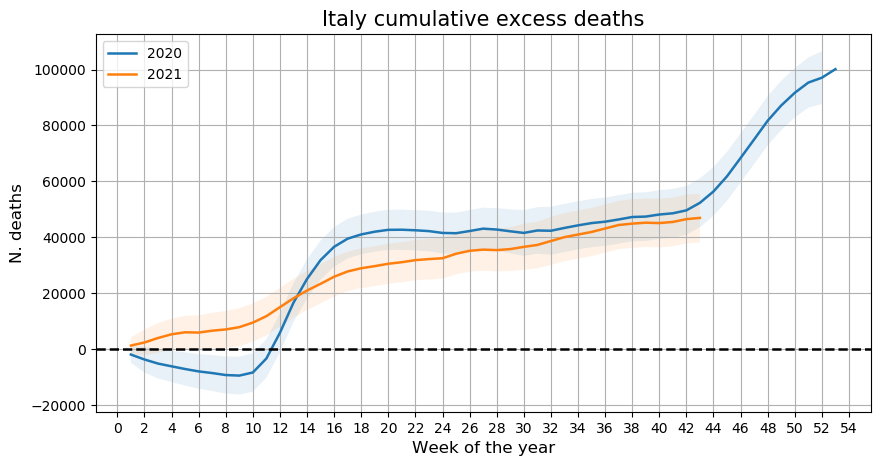

In [303]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Italy")

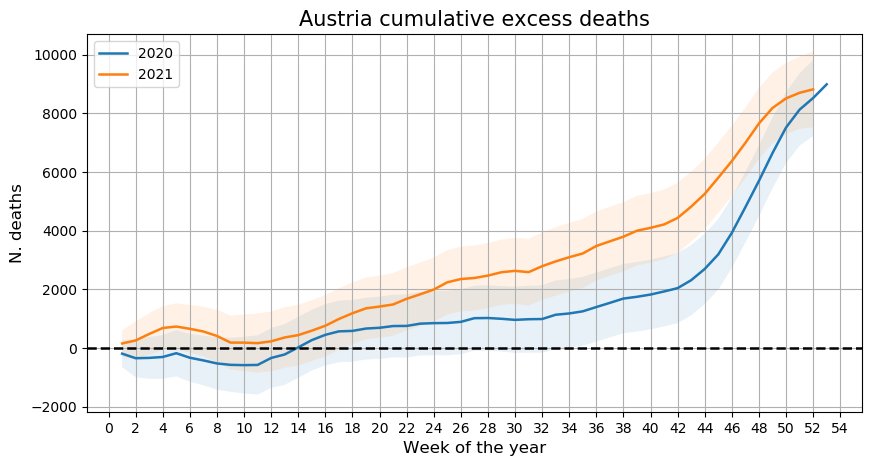

In [302]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Austria")

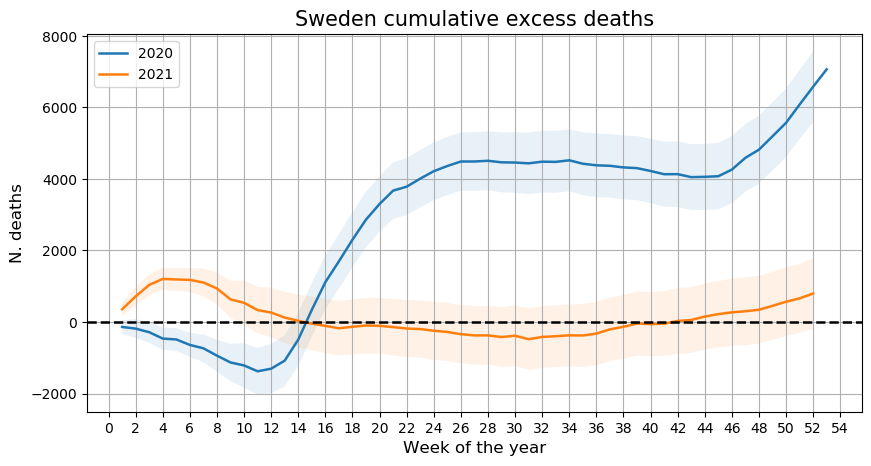

In [305]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Sweden")

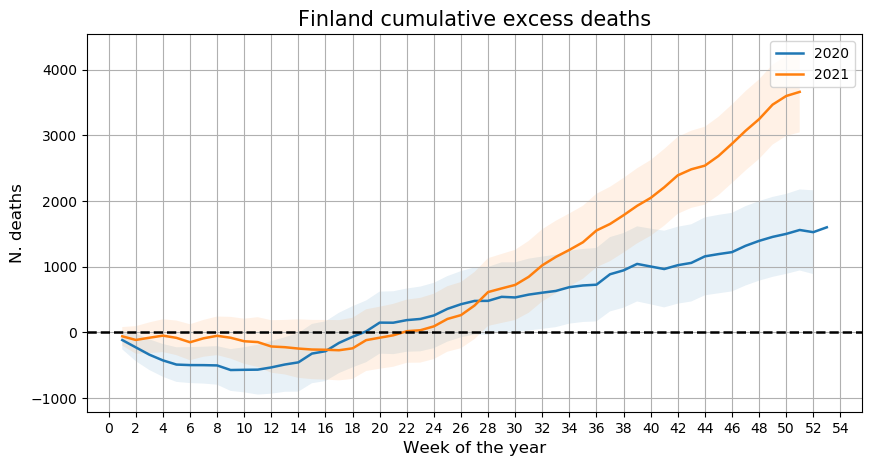

In [306]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Finland")

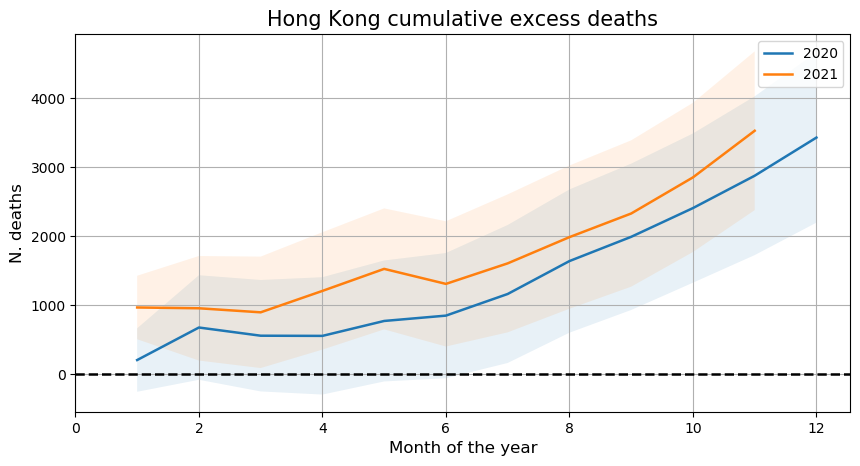

In [316]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Hong Kong")

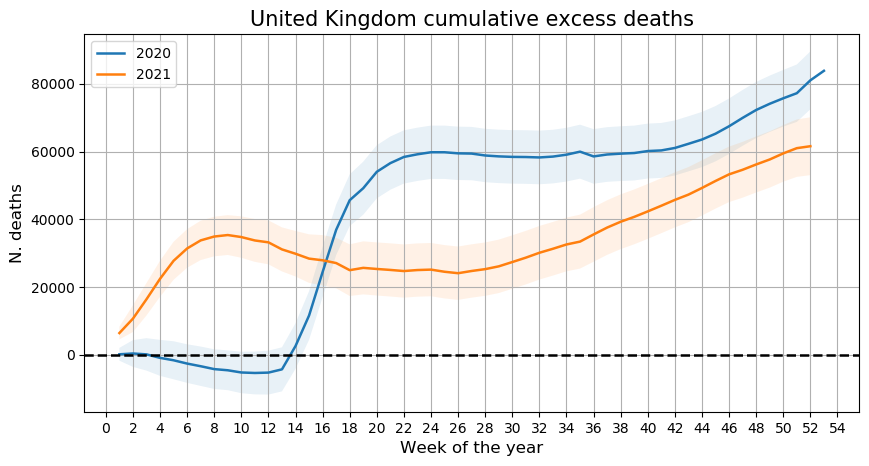

In [330]:
plot_mortality(varname="cumulative_excess_deaths",
               country="United Kingdom")

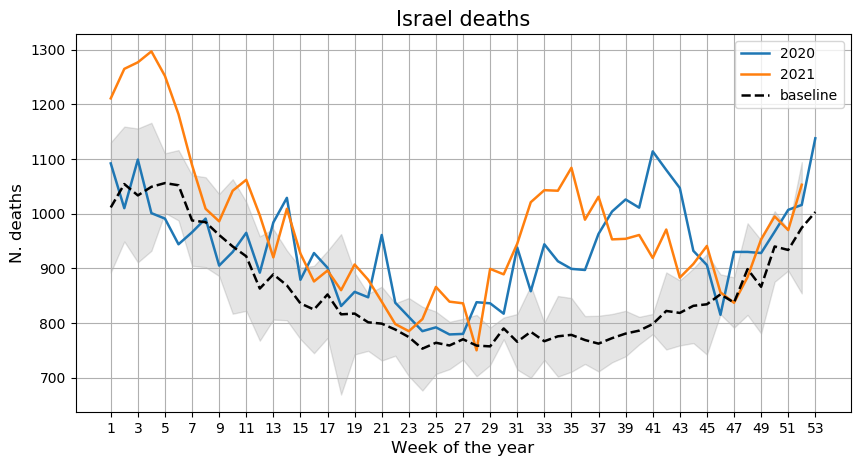

In [342]:
plot_mortality(varname="deaths",
               country="Israel")

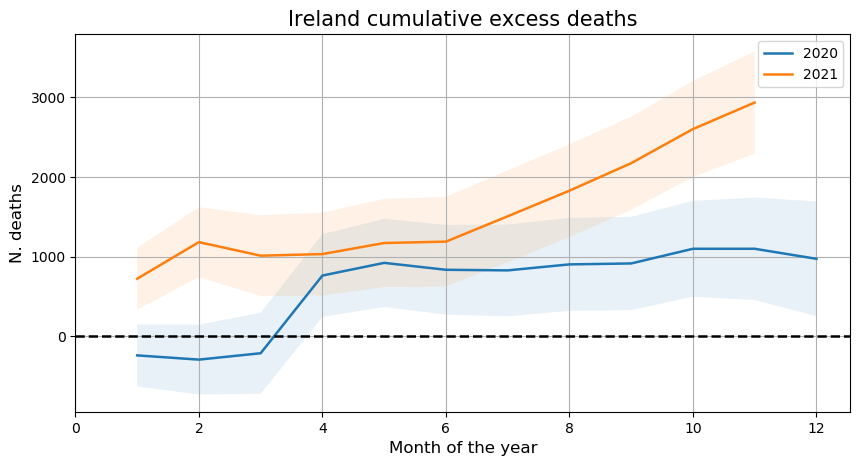

In [334]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Ireland")

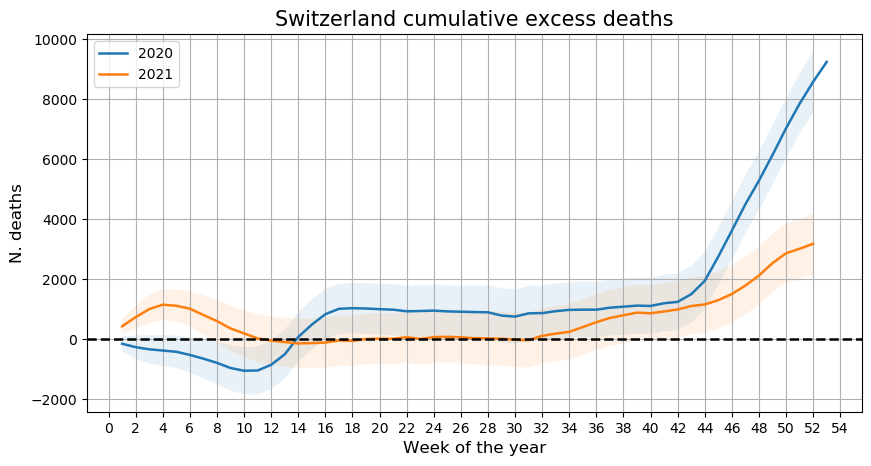

In [335]:
plot_mortality(varname="cumulative_excess_deaths",
               country="Switzerland")

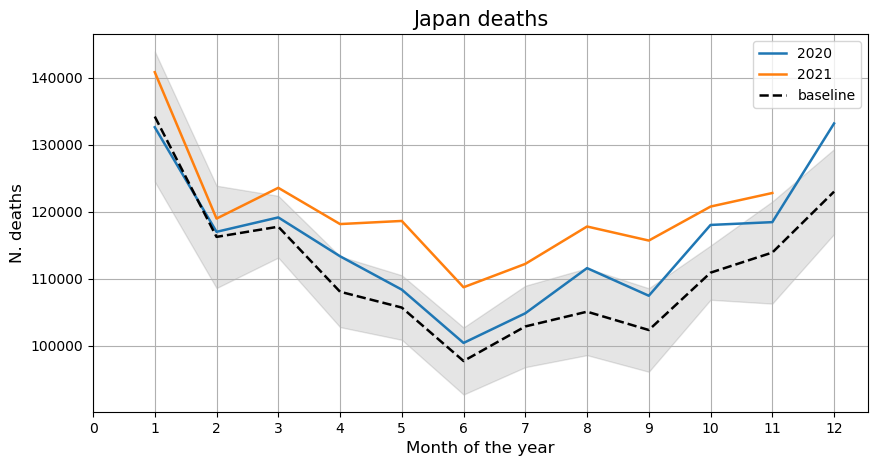

In [357]:
plot_mortality(varname="deaths",
               country="Japan")

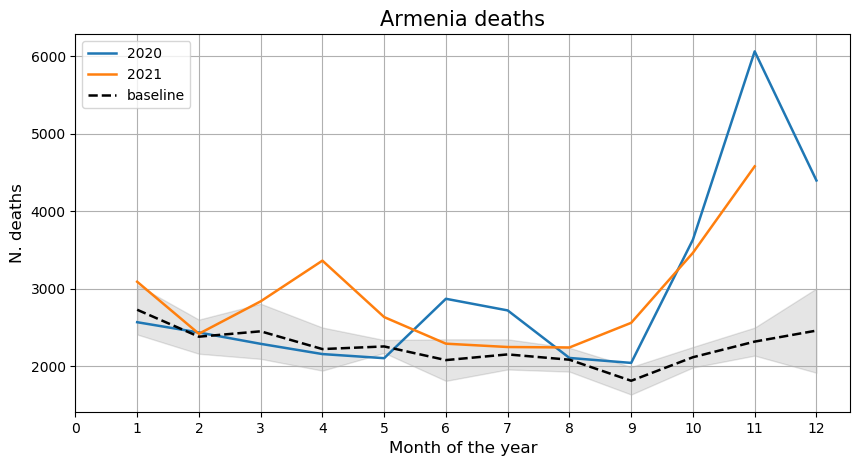

In [360]:
plot_mortality(varname="deaths",
               country="Armenia")